In [1]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.5f}'.format

import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
import seaborn as sns
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
# Model
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score ,roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, OneSidedSelection
from sklearn.preprocessing import Binarizer

In [3]:
df_good = pd.read_csv('./dataset/data_확장기.csv')
df_bad = pd.read_csv('./dataset/data_수축기.csv')
df_change = pd.read_csv('./dataset/data_전환기.csv')
df_all = pd.read_csv('./dataset/data_전체.csv')

df_good.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)
df_bad.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)
df_change.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)
df_all.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)

#### 함수

##### train, test 분리, 데이터 불균형 처리, 스케일링

In [4]:
def data(df):
    # scaler : StandardScaler(), RobustScaler()

    features = df.drop(['target'], axis=1)
    target = df['target']

    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=121, stratify=target, test_size=0.2)
    
    X_train, y_train = OneSidedSelection(sampling_strategy = 'auto', random_state=0, n_neighbors=1).fit_resample(X_train, y_train)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

##### 모델 평가

In [5]:
def score(y_test, pred):
    
    print('accuracy score : {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('precision score : {0:.3f}'.format(precision_score(y_test, pred)))
    print('recall score : {0:.3f}'.format(recall_score(y_test, pred)))
    print('f1 score : {0:.3f}'.format(f1_score(y_test, pred)))
    print('roc score : {0:.3f}'.format(roc_auc_score(y_test, pred)))
    
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap='YlOrBr', fmt='g')
    plt.xlabel('Predicted', fontsize=20)
    plt.ylabel('Actual', fontsize=20)

In [6]:
def get_f1_score(y_test, pred_proba_1):
    thresholds = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    accuracys = []
    precisions = []
    recalls = []
    f1_scores = []
    auc_scores=[]

    for threshold in thresholds:
        binarizer = Binarizer(threshold = threshold)
        pred_proba = binarizer.fit_transform(pred_proba_1)

        accuracy = accuracy_score(y_test, pred_proba)
        precision = precision_score(y_test, pred_proba)
        recall = recall_score(y_test, pred_proba)
        f1score = f1_score(y_test, pred_proba)
        auc_score=roc_auc_score(y_test, pred_proba)

        accuracys.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1score)
        auc_scores.append(auc_score)
    results = pd.DataFrame(data = {"Accuracy": accuracys, "Precision": precisions, "Recall": recalls, "F1 score": f1_scores,"Auc_Score":auc_scores}, index = thresholds)
    print(results)

##### 모델링

In [7]:
def LR(df):
    X_train, X_test, y_train, y_test = data(df)

    logistic = LogisticRegression()

    param_logit = {'penalty' : ['l1', 'l2'],
                   'C' : [0.001, 0.01, 0.1, 1, 10, 100],
                   'solver' : ['liblinear'],
                   'random_state' : [121],
                   'class_weight' : ['balanced']}

    gridsearch = GridSearchCV(logistic, param_grid = param_logit, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))


    # model_coef = pd.Series(best_model.best_estimator_.regressor_.coef_[0], df.drop(['target']).columns).sort_values(ascending=False)
    # model_coef

In [8]:
def DT(df):
    X_train, X_test, y_train, y_test = data(df)

    dt = DecisionTreeClassifier()
    param_dt = { 'criterion' : ['entropy'],   #giny : 속도 더 빠름, #엔트로피 : 균형적인 트리
                    'splitter' : ['best'],
                    'random_state' : [121],
                    'max_depth' : [5, 6, 7],
                    'min_samples_split' : [3, 5],
                    'class_weight' : ['balanced']}
    
    gridsearch = GridSearchCV(dt, param_grid = param_dt, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

    return gridsearch.fit(X_train, y_train)

In [9]:
def SVM(df, kernel):
    X_train, X_test, y_train, y_test = data(df)

    svc = SVC()
    param_svc = {'C' : [0.1, 0.5, 1.0],
                    'kernel' : [kernel],
                    'gamma' : [0.01, 0.1, 1.0, 10.0],
                    'random_state' : [121],
                    'class_weight' : ['balanced']}
    
    gridsearch = GridSearchCV(svc, param_grid = param_svc, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    pred = estimator.predict(X_test)
    # pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    # prediction = pd.concat([pred_probability, pred], axis = 1)
    # prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    # pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    # print(get_f1_score(y_test, pred_proba_1))

In [10]:
def XGB(df):
    X_train, X_test, y_train, y_test = data(df)

    xgb = XGBClassifier()
    param_xgb={'booster' :['gbtree'],
               'silent' : [1],
               'verbosity' : [0],
               'learning_rate' : [0.01, 0.05, 0.1],    # 나중에 한 번 더 확인
               'n_estimators' : [500],
               'min_child_weight' : [3, 5, 7],  ###
               'gamma' : [0.1, 1.0, 10.0],    ###
               'max_depth' : [4, 6],     ###
               'objective':['binary:logistic'],
               'colsample_bytree' : [0.6, 0.8],
               'colsample_bylevel' : [0.6, 0.8],
               'random_state' : [121],
               'scale_pos_weight' : [ len(df[df['target']==0])/len(df[df['target']==1]) ]
                }

    gridsearch = GridSearchCV(xgb, param_grid = param_xgb, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)
    
    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

#### Feature Selection

In [11]:
rfe_good = df_good[['유동비율', 'OCF', '총자본경상이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', '유형자산증가율', '순이익증가율', 'target']]
sfm_rf_good = df_good[['부채비율', 'OCF', '총자산이익률', '총자본경상이익률', '자기자본순이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', '순이익증가율', 'target']]
sfm_lr_good = df_good[['자기자본비율', '차입금의존도', '총자산이익률', '총자본경상이익률', '자기자본영업이익률', '매출원가율', '총자본회전율', '총자본증가율', '유형자산증가율', 'target']]
sfm_pi_good = df_good[['자기자본영업이익률', '총자본회전율', '총자산이익률', '총자본경상이익률', '순이익증가율', '자기자본회전율', '유동비율', 'OCF', 'target']]

In [12]:
rfe_bad = df_bad[['유동비율', 'OCF', '총자본경상이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', 'target']]
sfm_rf_bad = df_bad[['부채비율', 'OCF', '총자산이익률', '총자본경상이익률', '자기자본순이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', '순이익증가율', 'target']]
sfm_lr_bad = df_bad[['자기자본비율', '유동비율', '차입금의존도', '자기자본영업이익률', '매출원가율', '총자본회전율', '자기자본회전율', '총자본증가율', '유형자산증가율', 'target']]
sfm_pi_bad = df_bad[['자기자본영업이익률', '총자본회전율', '총자본경상이익률', '총자산이익률', '순이익증가율', '자기자본회전율', '유동비율', 'OCF', 'target']]

#### 확장기

##### Recursive Feature Elimination

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


최적 파라미터
 {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.5090845629148651

예측 데이터 정확도
accuracy score : 0.808
precision score : 0.338
recall score : 0.856
f1 score : 0.484
roc score : 0.829


findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.59271    0.20196 0.96801   0.33420    0.75820
0.30000   0.68877    0.24616 0.94417   0.39050    0.80139
0.40000   0.75932    0.29266 0.90276   0.44202    0.82257
0.50000   0.80755    0.33771 0.85571   0.48429    0.82879
0.60000   0.84266    0.37996 0.77541   0.51001    0.81301
0.70000   0.86459    0.40957 0.63927   0.49927    0.76523
0.80000   0.87287    0.40793 0.45169   0.42870    0.68715
0.90000   0.87705    0.37500 0.24655   0.29750    0.59902
None


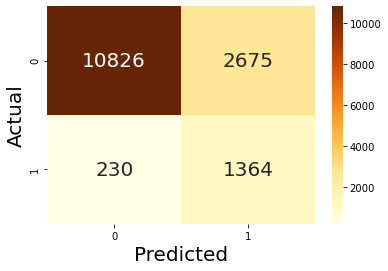

In [13]:
LR(rfe_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.6220717759971367

예측 데이터 정확도
accuracy score : 0.871
precision score : 0.448
recall score : 0.943
f1 score : 0.608
roc score : 0.903
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.81616    0.36422 0.99373   0.53306    0.89446
0.30000   0.81689    0.36508 0.99310   0.53390    0.89459
0.40000   0.85651    0.42160 0.96487   0.58680    0.90429
0.50000   0.87141    0.44826 0.94291   0.60764    0.90294
0.60000   0.88625    0.47986 0.91907   0.63051    0.90073
0.70000   0.89407    0.49912 0.89084   0.63978    0.89265
0.80000   0.90275    0.52455 0.84442   0.64712    0.87703
0.90000   0.91507    0.60670 0.55646   0.58050    0.75694
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

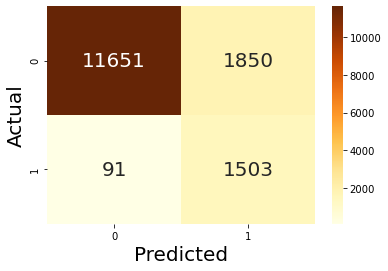

In [14]:
DT(rfe_good)

In [15]:
# SVM(rfe_good, 'rbf')

In [16]:
# XGB(rfe_good)

##### SelectFromModel_RandomForest

최적 파라미터
 {'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.5135232689737994

예측 데이터 정확도
accuracy score : 0.811
precision score : 0.343
recall score : 0.866
f1 score : 0.491
roc score : 0.835
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.60325    0.20594 0.96550   0.33947    0.76299
0.30000   0.69129    0.24761 0.94354   0.39228    0.80252
0.40000   0.75820    0.29308 0.91343   0.44377    0.82665
0.50000   0.81067    0.34302 0.86637   0.49146    0.83523
0.60000   0.84710    0.38947 0.78921   0.52156    0.82157
0.70000   0.86717    0.41717 0.64931   0.50798    0.77110
0.80000   0.87453    0.41611 0.46675   0.43998    0.69471
0.90000   0.88069    0.40133 0.26412   0.31858    0.60880
None


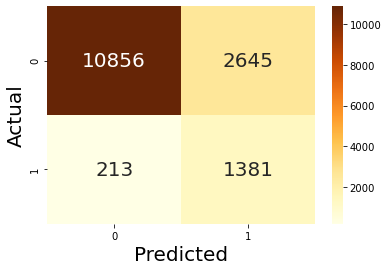

In [17]:
LR(sfm_rf_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.6232310395434182

예측 데이터 정확도
accuracy score : 0.862
precision score : 0.432
recall score : 0.961
f1 score : 0.596
roc score : 0.906
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.80841    0.35520 0.99875   0.52403    0.89234
0.30000   0.84319    0.40072 0.97867   0.56862    0.90293
0.40000   0.85459    0.41859 0.96926   0.58467    0.90515
0.50000   0.86227    0.43167 0.96110   0.59576    0.90585
0.60000   0.88235    0.47091 0.92409   0.62389    0.90075
0.70000   0.89241    0.49485 0.90339   0.63943    0.89725
0.80000   0.90149    0.52035 0.85822   0.64788    0.88241
0.90000   0.91679    0.61388 0.57152   0.59194    0.76454
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

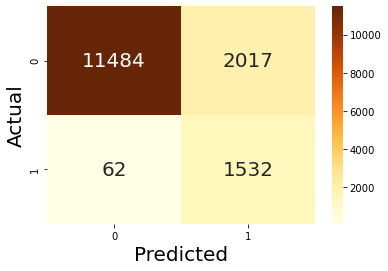

In [18]:
DT(sfm_rf_good)

In [19]:
# SVM(sfm_rf_good, 'rbf')

In [20]:
# XGB(sfm_rf_good)

##### SelectFromModel_Logistic Regression

최적 파라미터
 {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.49988445521969105

예측 데이터 정확도
accuracy score : 0.802
precision score : 0.328
recall score : 0.836
f1 score : 0.471
roc score : 0.817
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.58523    0.19979 0.97428   0.33159    0.75679
0.30000   0.69109    0.24749 0.94354   0.39213    0.80241
0.40000   0.75760    0.29103 0.90213   0.44009    0.82134
0.50000   0.80199    0.32816 0.83563   0.47125    0.81682
0.60000   0.83663    0.36618 0.74843   0.49176    0.79774
0.70000   0.86035    0.39753 0.62547   0.48610    0.75678
0.80000   0.86744    0.39112 0.45859   0.42218    0.68715
0.90000   0.87347    0.35234 0.23651   0.28303    0.59259
None


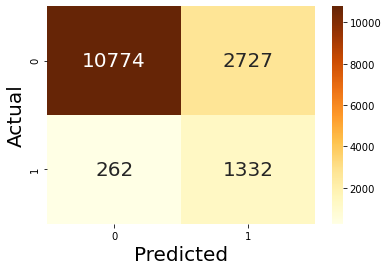

In [21]:
LR(sfm_lr_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 5, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.5709901631220904

예측 데이터 정확도
accuracy score : 0.824
precision score : 0.374
recall score : 0.991
f1 score : 0.543
roc score : 0.897
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.80768    0.35439 0.99937   0.52324    0.89221
0.30000   0.82365    0.37364 0.99059   0.54261    0.89727
0.40000   0.82365    0.37364 0.99059   0.54261    0.89727
0.50000   0.82365    0.37364 0.99059   0.54261    0.89727
0.60000   0.82763    0.37737 0.97302   0.54383    0.89174
0.70000   0.87334    0.44704 0.84191   0.58399    0.85948
0.80000   0.90547    0.54211 0.67440   0.60106    0.80357
0.90000   0.91474    0.64605 0.42597   0.51342    0.69921
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

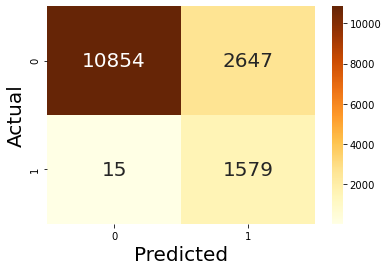

In [22]:
DT(sfm_lr_good)

In [23]:
# SVM(sfm_lr_good, 'rbf')

In [24]:
# XGB(sfm_lr_good)

##### Permutation Importance

최적 파라미터
 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.5087661907150999

예측 데이터 정확도
accuracy score : 0.808
precision score : 0.338
recall score : 0.855
f1 score : 0.484
roc score : 0.829
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.59218    0.20152 0.96612   0.33348    0.75708
0.30000   0.68705    0.24478 0.94166   0.38856    0.79932
0.40000   0.75952    0.29267 0.90151   0.44188    0.82213
0.50000   0.80762    0.33771 0.85508   0.48419    0.82855
0.60000   0.84359    0.38182 0.77729   0.51209    0.81435
0.70000   0.86479    0.40926 0.63237   0.49692    0.76230
0.80000   0.87267    0.40797 0.45609   0.43069    0.68897
0.90000   0.87731    0.37807 0.25094   0.30166    0.60110
None


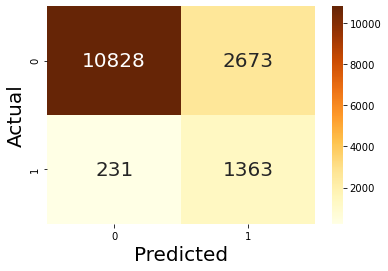

In [25]:
LR(sfm_pi_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.6206676901707096

예측 데이터 정확도
accuracy score : 0.874
precision score : 0.454
recall score : 0.941
f1 score : 0.612
roc score : 0.904
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.81683    0.36506 0.99373   0.53396    0.89483
0.30000   0.81683    0.36506 0.99373   0.53396    0.89483
0.40000   0.85028    0.41125 0.96801   0.57725    0.90219
0.50000   0.87406    0.45358 0.94103   0.61212    0.90359
0.60000   0.88102    0.46798 0.92597   0.62174    0.90084
0.70000   0.89506    0.50179 0.87829   0.63869    0.88767
0.80000   0.90242    0.52348 0.84630   0.64685    0.87767
0.90000   0.91567    0.61107 0.55395   0.58111    0.75616
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

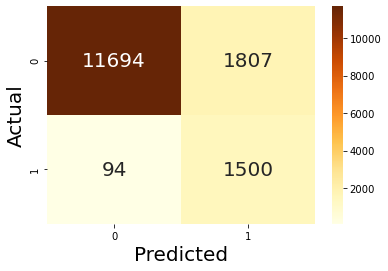

In [26]:
DT(sfm_pi_good)

In [27]:
# SVM(sfm_pi_good, 'rbf')

In [28]:
# XGB(sfm_pi_good)

#### 수축기

##### Recursive Feature Elimination

최적 파라미터
 {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.4287665655595235

예측 데이터 정확도
accuracy score : 0.789
precision score : 0.272
recall score : 0.879
f1 score : 0.415
roc score : 0.830
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.54653    0.15502 0.97311   0.26744    0.73999
0.30000   0.65590    0.19267 0.95462   0.32063    0.79137
0.40000   0.73324    0.23265 0.92941   0.37214    0.82221
0.50000   0.78914    0.27155 0.87899   0.41491    0.82989
0.60000   0.82745    0.30181 0.78319   0.43572    0.80738
0.70000   0.85161    0.30276 0.57143   0.39581    0.72454
0.80000   0.86934    0.29041 0.37143   0.32596    0.64353
0.90000   0.88392    0.22807 0.15294   0.18310    0.55241
None


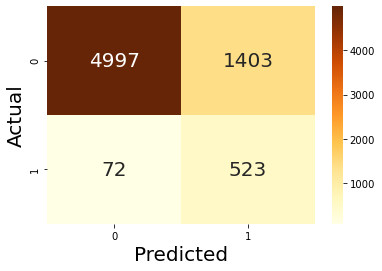

In [29]:
LR(rfe_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.4707455027193476

예측 데이터 정확도
accuracy score : 0.810
precision score : 0.298
recall score : 0.914
f1 score : 0.450
roc score : 0.857
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.77927    0.27565 0.97983   0.43026    0.87023
0.30000   0.77927    0.27565 0.97983   0.43026    0.87023
0.40000   0.77927    0.27565 0.97983   0.43026    0.87023
0.50000   0.80958    0.29808 0.91429   0.44959    0.85706
0.60000   0.80958    0.29808 0.91429   0.44959    0.85706
0.70000   0.87391    0.38247 0.78487   0.51432    0.83353
0.80000   0.88563    0.40500 0.73445   0.52210    0.81707
0.90000   0.92280    0.60300 0.27059   0.37355    0.62701
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

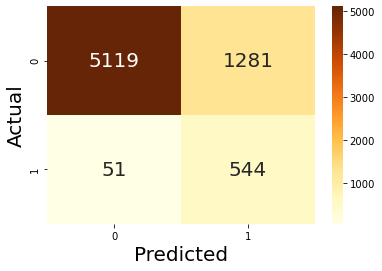

In [30]:
DT(rfe_bad)

In [31]:
# SVM(rfe_bad, 'rbf')

In [32]:
# XGB(rfe_bad)

##### SelectFromModel_RandomForest

최적 파라미터
 {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.43589830543839075

예측 데이터 정확도
accuracy score : 0.800
precision score : 0.285
recall score : 0.889
f1 score : 0.431
roc score : 0.841
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.57112    0.16231 0.97143   0.27815    0.75267
0.30000   0.66819    0.19719 0.94454   0.32627    0.79352
0.40000   0.74339    0.23822 0.91765   0.37825    0.82242
0.50000   0.80043    0.28456 0.88908   0.43113    0.84063
0.60000   0.83760    0.31833 0.79664   0.45489    0.81902
0.70000   0.86319    0.34039 0.64874   0.44650    0.76593
0.80000   0.87763    0.33418 0.44202   0.38061    0.68007
0.90000   0.88906    0.29291 0.21513   0.24806    0.58342
None


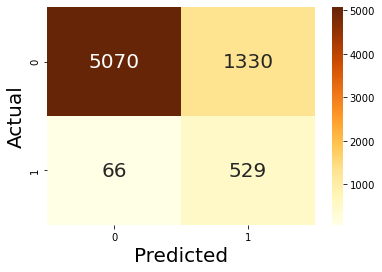

In [33]:
LR(sfm_rf_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.5137150840466924

예측 데이터 정확도
accuracy score : 0.842
precision score : 0.344
recall score : 0.950
f1 score : 0.505
roc score : 0.891
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.79757    0.29194 0.96807   0.44860    0.87489
0.30000   0.79757    0.29194 0.96807   0.44860    0.87489
0.40000   0.81601    0.31155 0.96134   0.47059    0.88192
0.50000   0.84160    0.34388 0.94958   0.50492    0.89057
0.60000   0.84346    0.34644 0.94790   0.50742    0.89082
0.70000   0.86905    0.38137 0.86723   0.52977    0.86822
0.80000   0.89621    0.43708 0.76471   0.55623    0.83657
0.90000   0.92051    0.55228 0.34622   0.42562    0.66006
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

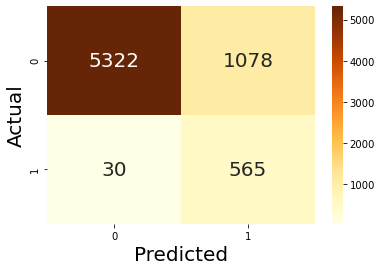

In [34]:
DT(sfm_rf_bad)

In [35]:
# SVM(sfm_rf_bad, 'rbf')

In [36]:
# XGB(sfm_rf_bad)

##### SelectFromModel_Logistic Regression

최적 파라미터
 {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.4306412580898811

예측 데이터 정확도
accuracy score : 0.790
precision score : 0.264
recall score : 0.824
f1 score : 0.400
roc score : 0.805
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.54853    0.15616 0.97815   0.26932    0.74337
0.30000   0.66748    0.19854 0.95798   0.32891    0.79923
0.40000   0.74639    0.24042 0.91765   0.38102    0.82406
0.50000   0.79014    0.26444 0.82353   0.40033    0.80528
0.60000   0.82273    0.28428 0.71429   0.40670    0.77355
0.70000   0.84632    0.29557 0.58319   0.39231    0.72699
0.80000   0.86276    0.29425 0.43866   0.35223    0.67042
0.90000   0.87877    0.22075 0.16807   0.19084    0.55646
None


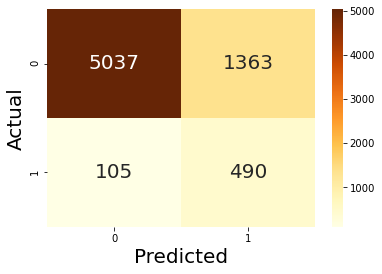

In [37]:
LR(sfm_lr_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.4720037196609578

예측 데이터 정확도
accuracy score : 0.785
precision score : 0.279
recall score : 0.965
f1 score : 0.433
roc score : 0.866
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.77327    0.27134 0.98824   0.42578    0.87076
0.30000   0.77613    0.27366 0.98655   0.42847    0.87156
0.40000   0.78470    0.27985 0.97311   0.43468    0.87015
0.50000   0.78485    0.27891 0.96471   0.43272    0.86642
0.60000   0.85547    0.35535 0.85882   0.50271    0.85699
0.70000   0.85847    0.35943 0.84874   0.50500    0.85406
0.80000   0.89378    0.42449 0.69916   0.52825    0.80552
0.90000   0.92051    0.53772 0.46723   0.50000    0.71494
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

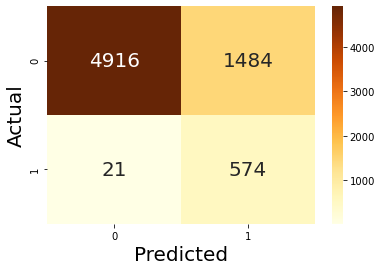

In [38]:
DT(sfm_lr_bad)

In [39]:
# SVM(sfm_lr_bad, 'rbf')

In [40]:
# XGB(sfm_lr_bad)

##### Permutation Importance

최적 파라미터
 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.4357524602187911

예측 데이터 정확도
accuracy score : 0.795
precision score : 0.276
recall score : 0.862
f1 score : 0.418
roc score : 0.826
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.55482    0.15765 0.97479   0.27141    0.74529
0.30000   0.66162    0.19511 0.95294   0.32391    0.79374
0.40000   0.73896    0.23481 0.91597   0.37380    0.81923
0.50000   0.79543    0.27551 0.86218   0.41758    0.82570
0.60000   0.83488    0.31004 0.76807   0.44176    0.80458
0.70000   0.86076    0.33004 0.61849   0.43041    0.75088
0.80000   0.87420    0.31225 0.39832   0.35007    0.65838
0.90000   0.88763    0.27739 0.20000   0.23242    0.57578
None


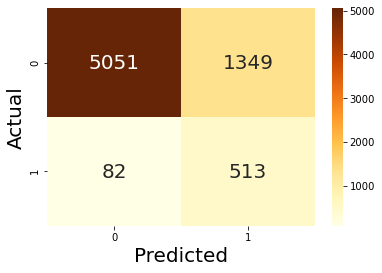

In [41]:
LR(sfm_pi_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.5118890306500844

예측 데이터 정확도
accuracy score : 0.833
precision score : 0.331
recall score : 0.938
f1 score : 0.489
roc score : 0.881
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.79442    0.28787 0.96134   0.44307    0.87013
0.30000   0.79442    0.28787 0.96134   0.44307    0.87013
0.40000   0.81229    0.30553 0.94790   0.46211    0.87379
0.50000   0.83317    0.33057 0.93782   0.48883    0.88063
0.60000   0.85261    0.35525 0.89916   0.50928    0.87372
0.70000   0.87320    0.38717 0.84202   0.53044    0.85906
0.80000   0.89764    0.43833 0.72269   0.54569    0.81830
0.90000   0.91894    0.53139 0.39832   0.45533    0.68283
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

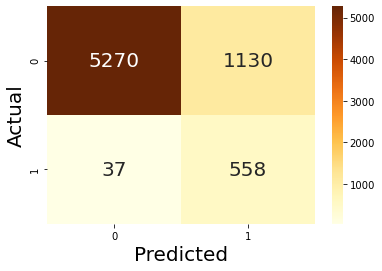

In [42]:
DT(sfm_pi_bad)

In [43]:
# SVM(sfm_pi_bad, 'rbf')

In [44]:
# XGB(sfm_pi_bad)